In [75]:
%matplotlib inline
# Parse xml
import pandas as pd
from pandas import *
import numpy as np
import glob
import json, re
import time
from dateutil.parser import parse

## Get Stackoverflow data into Pandas DataFrame object

In [77]:
df_posts = pd.read_csv("stackoverflow/posts.csv", encoding="utf-8")
df_posts.CreationDate = pd.to_datetime(df_posts.CreationDate)
df_badges = pd.read_csv("stackoverflow/badges.csv", encoding="utf-8")
df_users = pd.read_csv("stackoverflow/users.csv", encoding="utf-8")
df_comments = pd.read_csv("stackoverflow/comments.csv", encoding="utf-8")
df_votes = pd.read_csv("stackoverflow/votes.csv", encoding="utf-8")

In [78]:
# Columns for each table
print "Posts:"
print df_posts.columns
print "-"*70
print "Badges:"
print df_badges.columns
print "-"*70
print "Users:"
print df_users.columns
print "-"*70
print "Comments:"
print df_comments.columns
print "-"*70
print "Votes:"
print df_votes.columns
print "-"*70

Posts:
Index([            u'ViewCount', u'LastEditorDisplayName',
                  u'ClosedDate',      u'LastEditorUserId',
                    u'ParentID',          u'LastEditDate',
                u'CommentCount',           u'AnswerCount',
            u'AcceptedAnswerId',                 u'Score',
          u'CommunityOwnedDate',            u'PostTypeId',
                 u'OwnerUserId',                  u'Tags',
                u'CreationDate',         u'FavoriteCount',
                          u'Id',      u'LastActivityDate'],
      dtype='object')
----------------------------------------------------------------------
Badges:
Index([u'Date', u'UserId', u'Id', u'Name'], dtype='object')
----------------------------------------------------------------------
Users:
Index([     u'DownVotes',            u'Age',     u'WebsiteUrl',
           u'Reputation',          u'Views', u'LastAccessDate',
              u'UpVotes',   u'CreationDate',             u'Id'],
      dtype='object')
-------

In [20]:
# We can look at the top 5 post tags easily
df_posts.Tags[:3]
tags = []
for row in df_posts.Tags.dropna():
    for tag in row.split("><"):
        tags.append(tag.replace("<","").replace(">",""))
print "Length of tags: %i" % len(tags)
print tags[:3]

Length of tags: 117656
[u'bayesian', u'prior', u'elicitation']


In [79]:
s_top_tags = pd.Series(tags).value_counts().order(ascending=False)
print s_top_tags[:10]

r                     7244
regression            5413
time-series           2737
machine-learning      2564
probability           2081
hypothesis-testing    2000
distributions         1880
self-study            1784
logistic              1624
correlation           1585
dtype: int64


In [87]:
# Which fraction of posts contain the word machine-learning
total = len(df_posts.Tags)
dict_top_tags = {}
for top_tag in s_top_tags.index[:10]:
    frac = len(df_posts.Tags.dropna()[df_posts.Tags.dropna().str.contains("<"+top_tag+">")]) / float(total)
    dict_top_tags[top_tag] = frac*100
    print "%s:\n %f %%" % (top_tag, frac*100)

r:
 7.875968 %
regression:
 5.885231 %
time-series:
 2.975776 %
machine-learning:
 2.787684 %
probability:
 2.262547 %
hypothesis-testing:
 2.174480 %
distributions:
 2.044011 %
self-study:
 1.939636 %
logistic:
 1.765678 %
correlation:
 1.723276 %


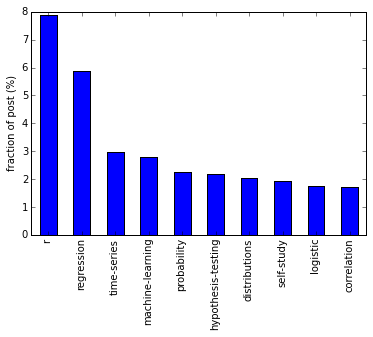

In [89]:
pd.Series(dict_top_tags).order(ascending=False).plot(kind='bar').set_ylabel("fraction of post (%)")

In [102]:
# We could also ask
# Find the average score of a question vs an answer
# PostTypeId = 1 (Question), 2 (Answer)
avg_question_score = df_posts[df_posts.PostTypeId==1].Score.mean()
avg_answer_score   = df_posts[df_posts.PostTypeId==2].Score.mean()
print "The average question scores: %f" % (avg_question_score)
print "The average answer scores: %f" % (avg_answer_score)

The average question scores: 2.491368
The average answer scores: 3.138017


In [117]:
# We could also look into the possible correlation of a user's reputation and total score from posts
# In the posts table is a OwnerUserId that is tied to the Id of the user where the reputation is stored
score_grouped_by_OwnerUserId = df_posts.Score.groupby(df_posts.OwnerUserId).sum()
score_grouped_by_OwnerUserId[:20]
users_reputation = df_users[["Reputation", "Id"]]

In [122]:
df_score_grouped_by_OwnerUserId = pd.DataFrame({"Id": score_grouped_by_OwnerUserId.index, "Score": score_grouped_by_OwnerUserId.values})
print df_score_grouped_by_OwnerUserId[:3]
print users_reputation[:3]

   Id  Score
0  -1      0
1   5   1463
2   6     85
   Reputation  Id
0           1  -1
1         101   2
2         101   3


In [125]:
merged_score_reputation = merge(df_score_grouped_by_OwnerUserId, users_reputation)
print merged_score_reputation[:3]

   Id  Score  Reputation
0  -1      0           1
1   5   1463        6792
2   6     85         457


In [129]:
merged_score_reputation[["Score", "Reputation"]].corr()

,Score,Reputation
Score,1.000000,0.984862
Reputation,0.984862,1.000000


In [130]:
#Lastly
# What time of the day should one post to get a fast accepted response. 
# This is done by lokking at the median response time of the accepted answer as a function of the question post hour
# The response time is the length of time in between when the question was first posted and when the accepted answer 
# was first posted in hours
# What is the range of response times across question post hours

In [132]:
from pandas.tseries.offsets import *
print df_posts[df_posts.Id==15].CreationDate

14   2010-07-19 19:19:46.160
Name: CreationDate, dtype: datetime64[ns]


In [137]:
# There is an AcceptedAnswerId in the posts table for questions that links to the answer's user ID
df_question_postdate = pd.DataFrame({"Id": df_posts.AcceptedAnswerId, "PostDate": df_posts.CreationDate})
df_question_postdate= df_question_postdate.dropna()

In [141]:
df_merge_answer_question = merge(df_question_postdate, df_posts[["Id","CreationDate"]], on='Id', how='inner')

In [144]:
df_merge_answer_question.columns = ["Id", "PostDate", "AnswerDate"]

In [148]:
df_merge_answer_question["ResponseTime"] = (df_merge_answer_question.AnswerDate-df_merge_answer_question.PostDate)/np.timedelta64(1,'h')

In [156]:
df_merge_answer_question["PostHour"] = pd.Series(pd.DatetimeIndex(df_merge_answer_question.PostDate).hour)

In [158]:
df_merge_answer_question[:3]

,Id,PostDate,AnswerDate,ResponseTime,PostHour
0,15,2010-07-19 19:12:12.510,2010-07-19 19:19:46.160,0.126014,19
1,59,2010-07-19 19:12:57.157,2010-07-19 19:43:20.423,0.506463,19
2,5,2010-07-19 19:13:28.577,2010-07-19 19:14:43.050,0.020687,19


In [163]:
# Group by post hour
grouped_by_posthour = df_merge_answer_question["ResponseTime"].groupby(df_merge_answer_question["PostHour"])

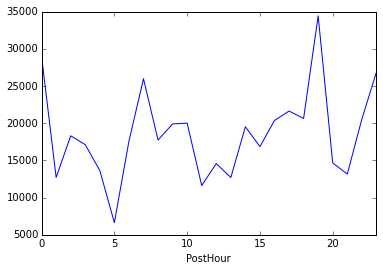

In [170]:
responsetime_by_hour = (grouped_by_posthour.max()-grouped_by_posthour.min())
responsetime_by_hour.plot()

In [180]:
print "Longest response time: %f hours" % (responsetime_by_hour.max())
print "Shortest response time: %f hours" % (responsetime_by_hour.min())
print "Longest - Shortest response time: %f hours" % (responsetime_by_hour.max()-responsetime_by_hour.min())

Longest response time: 34429.100302 hours
Shortest response time: 6636.008376 hours
Longest - Shortest response time: 27793.091926 hours
